# Extended Wigner's friend scenario

In [1]:
from typing import Optional
import itertools
import functools
import random
import numpy as np
import math
import matplotlib.pyplot as plt

from collections import defaultdict
from enum import Enum
from mitiq import zne

import qiskit
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.providers import Backend
from qiskit.providers import fake_provider
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

In [2]:
def extract_values_from_list_of_dicts(key, list_of_dicts):
    return [d[key][0] for d in list_of_dicts if key in d]

## Configurational settings

In [3]:
class Setting(Enum):
    PEEK = 1
    REVERSE_1 = 2
    REVERSE_2 = 3
    
class Observer(Enum):
    ALICE = 0
    BOB = 1

In [4]:
# Experiment settings (peek, reverse_1, and reverse_2).
PEEK = Setting.PEEK.value
REVERSE_1 = Setting.REVERSE_1.value
REVERSE_2 = Setting.REVERSE_2.value
SETTINGS = [PEEK, REVERSE_1, REVERSE_2]

# "Super"-observers (Alice and Bob).
ALICE = Observer.ALICE.value
BOB = Observer.BOB.value
OBSERVERS = [ALICE, BOB]

# Angles and beta term used for Alice and Bob measurement operators from arXiv:1907.05607.
# Note that despite the fact that degrees are used, we need to convert this to radians.
ANGLES = {PEEK: np.deg2rad(168), REVERSE_1: np.deg2rad(0), REVERSE_2: np.deg2rad(118)}
BETA = np.deg2rad(175)

## EWFS circuit

In [5]:
def prepare_bipartite_system(qc: QuantumCircuit):
    """Generates the state: 1/sqrt(2) * (|01> - |10>)"""
    qc.x(ALICE)
    qc.x(BOB)
    qc.h(ALICE)
    qc.cx(ALICE, BOB)


def cnot_ladder(qc: QuantumCircuit, observer: Observer, friend_qubit: int, friend_size: int):
    """CNOT ladder circuit (GHZ without Hadamard)."""
    for i in range(friend_size):
        qc.cx(observer, friend_qubit + i)


def ewfs_rotation(qc: QuantumCircuit, qubit: int, angle: float):
    qc.rz(-angle, qubit)
    qc.h(qubit)
    

def apply_setting(
    qc: QuantumCircuit,
    observer: Observer,
    setting: Setting,
    angle: float,
    friend_qubits: list[int],
    friend_size: int,
):
    """Apply either the PEEK or REVERSE_1/REVERSE_2 settings."""
    if setting is PEEK:
        # Ask friend for the outcome. We pick a random qubit from friend's register.
        random_offset = random.randint(0, friend_size - 1)
        qc.measure(friend_qubits[0] + random_offset, observer)

    elif setting in [REVERSE_1, REVERSE_2]:
        cnot_ladder(qc, observer, friend_qubits[0], friend_size)

        # For either REVERSE_1 or REVERSE_2, apply the appropriate angle rotations.
        # Note that in this case, the rotation should occur on the observer's qubit.
        if observer is ALICE:
            qc.h(ALICE)
            qc.rz(ANGLES[1], ALICE)        

        if observer is BOB:
            qc.h(BOB)        
            qc.rz((BETA - ANGLES[1]), BOB)
        ewfs_rotation(qc, observer, angle)            
        qc.measure(observer, observer)
        

def ewfs(
    alice_setting: Setting,
    bob_setting: Setting,
    angles: list[float],
    beta: float,
    charlie_size: int,
    debbie_size: int,
) -> QuantumCircuit:
    """Generate the circuit for extended Wigner's friend scenario."""
    alice_size, bob_size = 1, 1
    sys_size = alice_size + bob_size
    
    # Qubit sizes for friends.
    charlie_qubits = range(sys_size, (sys_size + charlie_size))
    debbie_qubits = range(sys_size + charlie_size, sys_size + (charlie_size + debbie_size))
        
    # Define quantum registers
    alice, bob, charlie, debbie = [
        QuantumRegister(size, name=name) 
        for size, name in zip([alice_size, bob_size, charlie_size, debbie_size], 
                              ["Alice", "Bob", "Charlie", "Debbie"])
    ]
    measurement = ClassicalRegister(sys_size, name="Measurement")
    
    # Create the Quantum Circuit with the defined registers
    qc = QuantumCircuit(alice, bob, charlie, debbie, measurement)
    
    # Prepare the bipartite quantum system
    prepare_bipartite_system(qc)
    
    # Rotations for measurement.
    ewfs_rotation(qc, ALICE, angles[1])
    ewfs_rotation(qc, BOB, beta - angles[1])

    # Apply the CNOT ladder for Alice-Charlie and Bob-Debbie
    cnot_ladder(qc, ALICE, charlie_qubits[0], charlie_size)
    cnot_ladder(qc, BOB, debbie_qubits[0], debbie_size)
    
    # Applie settings for Alice (and friend Charlie) and Bob (and friend Debbie).
    apply_setting(qc, ALICE, alice_setting, angles[alice_setting], charlie_qubits, charlie_size)
    apply_setting(qc, BOB, bob_setting, (beta - angles[bob_setting]), debbie_qubits, debbie_size)

    return qc

## Expectation values

In [6]:
def single_expect(observer: Observer, setting: Setting, results: dict) -> dict[str, float]:
    """Compute single expectation values for either Alice or Bob."""
    if observer is ALICE:
        ret = 0
        for settings in results.keys():
            if settings[ALICE] is setting:
                probs = results[settings]
                # <A> = P(00) + P(01) - P(10) - P(11)
                ret += (
                    probs.get("00", 0)
                    + probs.get("01", 0)
                    - probs.get("10", 0)
                    - probs.get("11", 0)
                )
        return ret / len(SETTINGS)
    else:
        ret = 0
        for settings in results.keys():
            if settings[BOB] is setting:
                probs = results[settings]
                # <B> = P(00) - P(01) + P(10) - P(11)
                ret += (
                    probs.get("00", 0)
                    - probs.get("01", 0)
                    + probs.get("10", 0)
                    - probs.get("11", 0)
                )
        return ret / len(SETTINGS)

In [7]:
def double_expect(settings: list[Setting], results: dict) -> float:
    """Expectation value of product of two operators."""
    probs = results[settings]
    # <AB> = P(00) - P(01) - P(10) + P(11)
    return (
        probs.get("00", 0) 
        - probs.get("01", 0) 
        - probs.get("10", 0) 
        + probs.get("11", 0)
    )    

## Experiments

In [8]:
def execute(    
    circuit: QuantumCircuit,
    backend: Backend,
    noise_model: NoiseModel,
    shots: float,
    bitstring: str,
):
    job = qiskit.execute(
        experiments=circuit,
        backend=backend,
        noise_model=noise_model,
        basis_gates=noise_model.basis_gates if noise_model is not None else None,
        optimization_level=0,  # Important to preserve folded gates.        
        shots=shots,
    )
    counts = job.result().get_counts()
    probabilities = {key[::-1]: value / shots for key, value in counts.items()}
    print(probabilities)
    return probabilities[bitstring]

In [9]:
def generate_all_experiments(
    backend: Backend,
    noise_model: NoiseModel,
    shots: float,
    angles: list[float],
    beta: float,
    charlie_size: int,
    debbie_size: int,
    use_zne: bool = False
) -> dict[tuple[Observer, Observer], list[float]]:
    """Generate probabilities for all combinations of experimental settings."""
    all_experiment_combos = list(itertools.product(SETTINGS, repeat=2))
    
    results = {}
    for alice_setting, bob_setting in all_experiment_combos:
        ewfs_circuit = ewfs(
            alice_setting=alice_setting,
            bob_setting=bob_setting, 
            angles=angles,
            beta=beta,
            charlie_size=charlie_size,
            debbie_size=debbie_size
        )
        if use_zne:
            result = {} 
            for bitstring in ["00", "01", "10", "11"]:
                executor = functools.partial(
                    execute, backend=backend, noise_model=noise_model, shots=shots, bitstring=bitstring
                )
                result[bitstring] = zne.execute_with_zne(ewfs_circuit, executor)
            results[(alice_setting, bob_setting)] = result
            
        else:
            job = qiskit.execute(
                experiments=ewfs_circuit,
                backend=backend,
                noise_model=noise_model,
                basis_gates=noise_model.basis_gates if noise_model is not None else None,
                optimization_level=0,  # Important to preserve folded gates.        
                shots=shots,
            )
            counts = job.result().get_counts()
            results[(alice_setting, bob_setting)] = {key[::-1]: value / shots for key, value in counts.items()}            
    return results

In [10]:
def compute_inequalities(results: dict, verbose: bool = False) -> dict[str, float]:
    A1 = single_expect(ALICE, PEEK, results)
    B1 = single_expect(BOB, PEEK, results)

    A2 = single_expect(ALICE, REVERSE_1, results)
    B2 = single_expect(BOB, REVERSE_1, results)

    A1B1 = double_expect((PEEK, PEEK), results)
    A1B2 = double_expect((PEEK, REVERSE_1), results)
    A1B3 = double_expect((PEEK, REVERSE_2), results)

    A2B1 = double_expect((REVERSE_1, PEEK), results)
    A2B2 = double_expect((REVERSE_1, REVERSE_1), results)
    A2B3 = double_expect((REVERSE_1, REVERSE_2), results)

    A3B1 = double_expect((REVERSE_2, PEEK), results)
    A3B2 = double_expect((REVERSE_2, REVERSE_1), results)
    A3B3 = double_expect((REVERSE_2, REVERSE_2), results)
    
    # Local-friendliness inequalities:
    # Eq. (13) from [1].
    lf = -A1 - A2 - B1 - B2 - A1B1 - 2*A1B2 - 2*A2B1 + 2*A2B2 - A2B3 - A3B2 - A3B3 - 6
    # Eq. (15) from [1].
    I3322 = -A1 + A2 + B1 - B2 + A1B1 - A1B2 - A1B3 - A2B1 + A2B2 - A2B3 - A3B1 - A3B2 - 4 

    # Brukner inequalities:
    # Eq. (17) from [1].
    brukner = A1B1 - A1B3 - A2B1 - A2B3 - 2
    # Eq. (18) from [1].
    semi_brukner = -A1B2 + A1B3 - A3B2 - A3B3 - 2

    # Bell non-LF 
    # Eq. (22) from [1].
    bell_non_lf = A2B2 - A2B3 - A3B2 - A3B3 - 2
    
    if verbose:
        print("******Inequalities******")
        print(f"{semi_brukner=} -- is violated: {semi_brukner > 0}")
        print(f"{brukner=} -- is violated: {brukner > 0}")
        print(f"{lf=} -- is violated: {lf > 0}")
        print(f"{I3322=} -- is_violated: {I3322 > 0}")
        print(f"{bell_non_lf=} -- is_violated: {bell_non_lf > 0}")
        print("**************************")
        
    return {
        "lf": lf,
        "I3322": I3322,
        "brukner": brukner,
        "semi_brukner": semi_brukner,
        "bell_non_lf": bell_non_lf,
    }

### EWFS circuit

/Users/vrusso/Projects/research/wigners_friend/venv/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


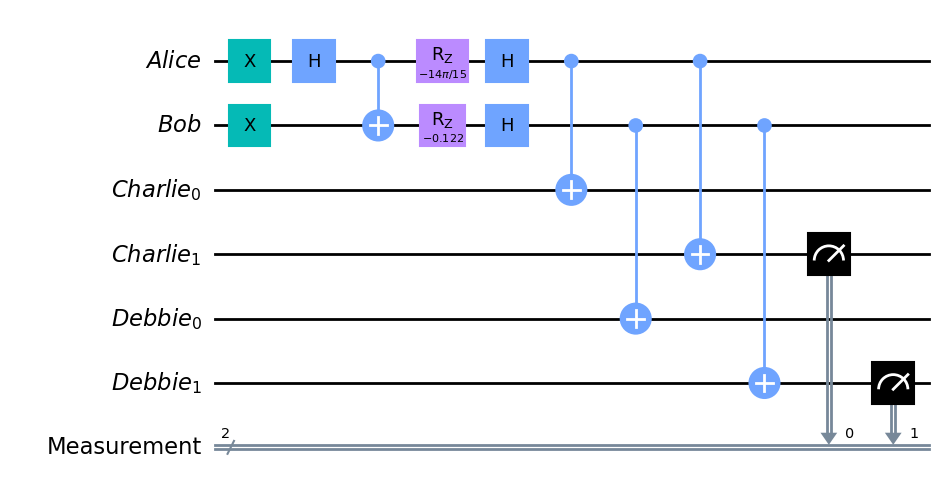

In [11]:
qc = ewfs(PEEK, PEEK, ANGLES, BETA, charlie_size=2, debbie_size=2)
qc.draw("mpl")#.savefig("ewfs_peek_peek.pdf")
#print(qc.draw("latex_source"))

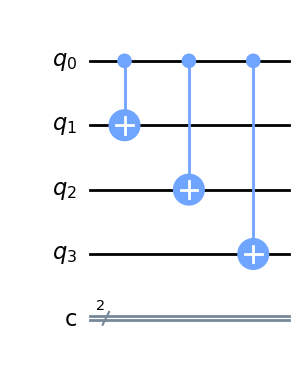

In [12]:
circuit = QuantumCircuit(4, 2)
cnot_ladder(circuit, 0, 1, 3)
circuit.draw("mpl")

## Experiments

In [13]:
def run_experiment(
    backend: Backend,
    noise_model: NoiseModel,
    friend_sizes: list[int],
    shots: float,
    use_zne: bool = False,
    verbose: bool = True,
    num_trials: int = 1
):
    all_results = {
        fs: {inequality: [] for inequality in ["lf", "I3322", "brukner", "semi_brukner", "bell_non_lf"]}
        for fs in friend_sizes
    }

    for friend_size in friend_sizes:
        for _ in range(num_trials):
            results = generate_all_experiments(
                backend=backend,
                noise_model=noise_model,
                shots=shots,
                angles=ANGLES,
                beta=BETA,
                charlie_size=friend_size,
                debbie_size=friend_size,
                use_zne=use_zne,
            )
            violations = compute_inequalities(results, verbose=verbose)

            for key in violations:
                all_results[friend_size][key].append(violations[key])

    return all_results

## Plotting

In [14]:
def plot_results(
    results: dict, 
    friend_sizes: list[int], 
    plot_error_bars: bool = False, 
    plot_file_name: str = "output.pdf"
):
    # Compute averages and standard deviations
    avg_results = {}
    std_results = {}
    for fs in results:
        avg_results[fs] = {}
        std_results[fs] = {}
        for key in results[fs]:
            avg_results[fs][key] = np.mean(results[fs][key])
            if plot_error_bars:
                std_results[fs][key] = np.std(results[fs][key])

    # Plotting
    plt.figure(figsize=(10, 6))
    markers = ["o", "s", "^", "*", "H"]
    colors = ["tab:green", "tab:orange", "tab:pink", "tab:blue", "tab:purple"]
    titles = ["LF", "I3322", "Brukner", "Semi-Brukner", "Bell non-LF"]

    for i, key in enumerate(["lf", "I3322", "brukner", "semi_brukner", "bell_non_lf"]):
        means = [avg_results[fs][key] for fs in friend_sizes]
        errors = [std_results[fs][key] for fs in friend_sizes] if plot_error_bars else None
        plt.errorbar(friend_sizes, means, yerr=errors, label=titles[i], fmt=markers[i], color=colors[i], capsize=5)

    plt.axhline(0, color="red", linestyle="dashed")
    plt.xticks(friend_sizes)
    plt.xlabel("Friend Size")
    plt.ylabel("Inequality violation value")    
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.savefig(plot_file_name, bbox_inches="tight")
    plt.show()

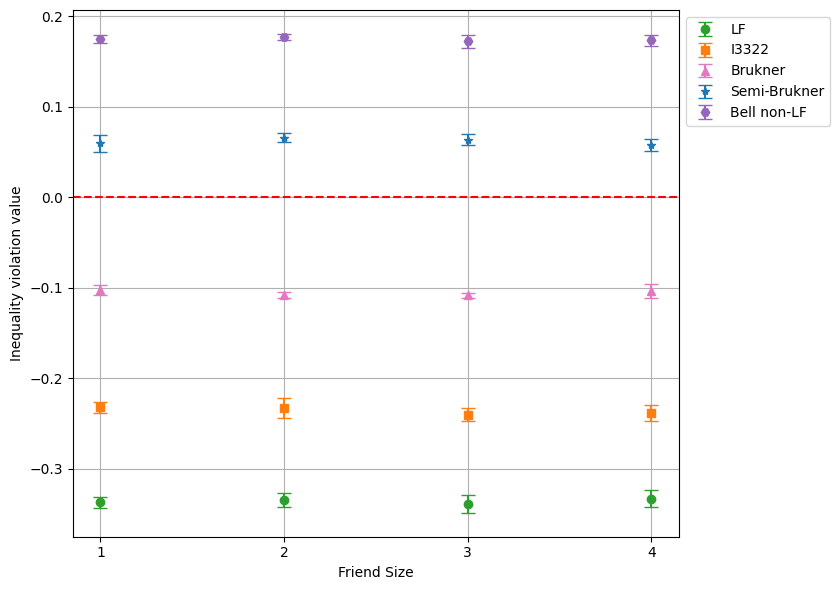

In [15]:
# TODO: Look at the dependence of friend size on Fake devices (FakeKolkata + others) to see if increasing friend size decreases violation value.
# TODO: Amplitude damping noise model instead to see what the behavior?
# TODO: Refactor and improve the plotting code and reproducibility of things.
# TODO: 
backend = qiskit.Aer.get_backend("aer_simulator")
# noise_model = None
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.02, 1), ["u1", "u2", "u3"])   
friend_sizes = range(1, 5)
num_trials = 10
shots = 50_000

results = run_experiment(
    backend=backend,
    noise_model=noise_model,
    friend_sizes=friend_sizes,
    num_trials=num_trials,
    shots=shots,    
    verbose=False,
)

plot_results(
    results, friend_sizes, plot_error_bars=True, plot_file_name="ewfs_ghz_ideal_simulator_friend_size.pdf"
)

### Noise vs. friend size violations

In [20]:
def data_noise_levels_per_friend_size(
    noise_levels: list[float], 
    friend_sizes: list[int], 
    shots: int
):
    """Data for noise_levels over friend_sizes."""
    plot_results = defaultdict(lambda: defaultdict(list))
    for friend_size in friend_sizes:
        for noise_level in noise_levels:
            print(f"{friend_size=}, {noise_level=}")

            noise_model = NoiseModel()
            noise_model.add_all_qubit_quantum_error(depolarizing_error(noise_level, 1), ["u1", "u2", "u3"])
            result = run_experiment(
                backend=qiskit.Aer.get_backend("aer_simulator"),
                noise_model=noise_model,
                friend_size=friend_size,
                shots=shots,
                verbose=False
            )
            for key in result:
                plot_results[friend_size][key].append(result[key][0])
    return plot_results

In [149]:
friend_sizes = range(1, 7)
noise_levels = np.linspace(0, 0.05, 6)
shots = 10_000

plot_data = data_noise_levels_per_friend_size(
    noise_levels=noise_levels, 
    friend_sizes=friend_sizes, 
    shots=shots,
)

TypeError: data_noise_levels_per_friend_size() got an unexpected keyword argument 'backend'

In [88]:
def plot_noise_levels_per_friend_size(
    plot_data,
    noise_levels: list[float], 
    friend_sizes: list[int],
    plot_file_name,
):    
    """Plot how EWFS behaves across noise levels for set of friend sizes."""
    plot_attrs = {
        "lf": {"marker": "o", "color": "tab:green", "title": "LF"},
        "I3322": {"marker": "s", "color": "tab:orange", "title": "I3322"},
        "brukner": {"marker": "^", "color": "tab:pink", "title": "Brukner"},
        "semi_brukner": {"marker": "*", "color": "tab:blue", "title": "Semi-Brukner"},
        "bell_non_lf": {"marker": "H", "color": "tab:purple", "title": "Bell non-LF"}
    }

    # Set the number of columns to 2 and calculate the number of rows needed
    num_cols = 3
    num_rows = math.ceil(len(friend_sizes) / num_cols)

    # Create the subplots in a 2-column grid
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5 * num_rows))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    # Iterate over each friend size and plot
    for i, friend_size in enumerate(friend_sizes):
        ax = axes[i]
        for key, settings in plot_attrs.items():
            ax.plot(
                noise_levels, plot_data[friend_size][key], label=settings["title"],
                marker=settings["marker"], color=settings["color"]
            )
        ax.axhline(0, color="red", linestyle="dotted")
        ax.set_title(f"Friend size {friend_size}")
        ax.legend()

    # Hide any unused axes
    for i in range(len(friend_sizes), len(axes)):
        axes[i].axis('off')

    # Set shared x-label and y-label for the entire figure
    fig.text(0.5, 0.04, "Noise Level", ha="center", va="center", fontsize=12)
    fig.text(0.04, 0.5, "Value", ha="center", va="center", rotation="vertical", fontsize=12)

    plt.tight_layout(rect=[0.07, 0.08, 1, 0.95])
    plt.savefig(plot_file_name, bbox_inches="tight")
    plt.show()

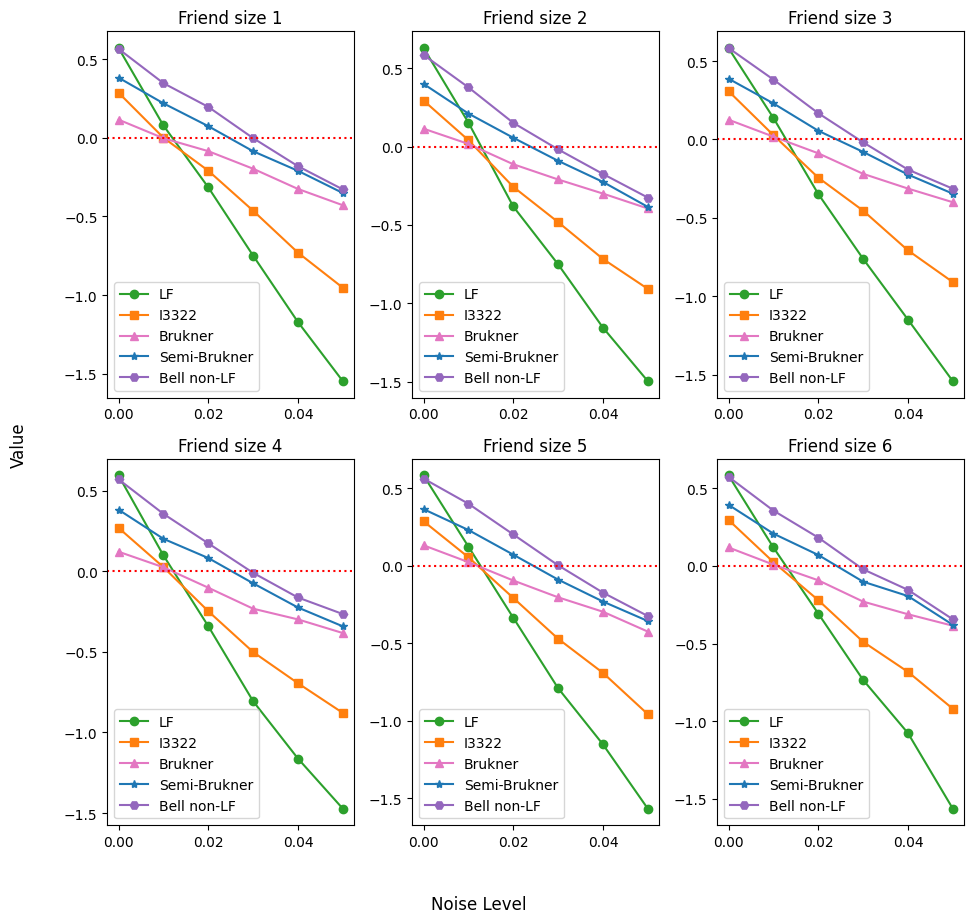

In [89]:
plot_noise_levels_per_friend_size(
    plot_data=plot_data, 
    noise_levels=noise_levels, 
    friend_sizes=friend_sizes, 
    plot_file_name="ghz_noise_levels_vs_friend_sizes.pdf"
)

### Friend size vs. noise violations

In [97]:
def data_friend_size_per_noise_level(
    noise_levels: list[float], 
    friend_sizes: list[int], 
    shots: int
):
    """Data for friend_sizes over noise_levels."""
    plot_results = defaultdict(lambda: defaultdict(list))
    for noise_level in noise_levels:
        noise_model = NoiseModel()
        noise_model.add_all_qubit_quantum_error(depolarizing_error(noise_level, 1), ["u1", "u2", "u3"])        
        for friend_size in friend_sizes:
            print(f"{noise_level=}, {friend_size=}")
            result = run_experiment(
                backend=qiskit.Aer.get_backend("aer_simulator"),
                noise_model=noise_model,
                friend_size=friend_size,
                shots=shots,
                verbose=False
            )
            for key in result:
                plot_results[noise_level][key].append(result[key][0])
    return plot_results

In [109]:
friend_sizes = range(1, 7)
noise_levels = np.linspace(0, 0.05, 6)
shots = 10_000

plot_data = data_friend_size_per_noise_level(
    noise_levels=noise_levels, 
    friend_sizes=friend_sizes, 
    shots=shots,
)

noise_level=0.0, friend_size=1
noise_level=0.0, friend_size=2
noise_level=0.0, friend_size=3
noise_level=0.0, friend_size=4
noise_level=0.0, friend_size=5
noise_level=0.0, friend_size=6
noise_level=0.01, friend_size=1
noise_level=0.01, friend_size=2
noise_level=0.01, friend_size=3
noise_level=0.01, friend_size=4
noise_level=0.01, friend_size=5
noise_level=0.01, friend_size=6
noise_level=0.02, friend_size=1
noise_level=0.02, friend_size=2
noise_level=0.02, friend_size=3
noise_level=0.02, friend_size=4
noise_level=0.02, friend_size=5
noise_level=0.02, friend_size=6
noise_level=0.03, friend_size=1
noise_level=0.03, friend_size=2
noise_level=0.03, friend_size=3
noise_level=0.03, friend_size=4
noise_level=0.03, friend_size=5
noise_level=0.03, friend_size=6
noise_level=0.04, friend_size=1
noise_level=0.04, friend_size=2
noise_level=0.04, friend_size=3
noise_level=0.04, friend_size=4
noise_level=0.04, friend_size=5
noise_level=0.04, friend_size=6
noise_level=0.05, friend_size=1
noise_level=0.

In [110]:
def plot_friend_size_per_noise_levels(
    plot_data,
    noise_levels: list[float], 
    friend_sizes: list[int],
    plot_file_name,
):    
    """Plot how EWFS behaves across noise levels for set of friend sizes."""
    plot_attrs = {
        "lf": {"marker": "o", "color": "tab:green", "title": "LF"},
        "I3322": {"marker": "s", "color": "tab:orange", "title": "I3322"},
        "brukner": {"marker": "^", "color": "tab:pink", "title": "Brukner"},
        "semi_brukner": {"marker": "*", "color": "tab:blue", "title": "Semi-Brukner"},
        "bell_non_lf": {"marker": "H", "color": "tab:purple", "title": "Bell non-LF"}
    }

    # Set the number of columns to 2 and calculate the number of rows needed
    num_cols = 2
    num_rows = math.ceil(len(friend_sizes) / num_cols)

    # Create the subplots in a 2-column grid
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5 * num_rows))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    # Iterate over each friend size and plot
    for i, noise_level in enumerate(noise_levels):
        ax = axes[i]
        for key, settings in plot_attrs.items():
            ax.plot(
                friend_sizes, plot_data[noise_level][key], label=settings["title"],
                marker=settings["marker"], color=settings["color"]
            )
        ax.axhline(0, color="red", linestyle="dotted")
        ax.set_title(f"Noise level {noise_level}")
        ax.legend()

    # Hide any unused axes
    for i in range(len(noise_levels), len(axes)):
        axes[i].axis('off')

    # Set shared x-label and y-label for the entire figure
    fig.text(0.5, 0.04, "Friend size", ha="center", va="center", fontsize=12)
    fig.text(0.04, 0.5, "Value", ha="center", va="center", rotation="vertical", fontsize=12)

    plt.tight_layout(rect=[0.07, 0.08, 1, 0.95])
    plt.savefig(plot_file_name, bbox_inches="tight")
    plt.show()

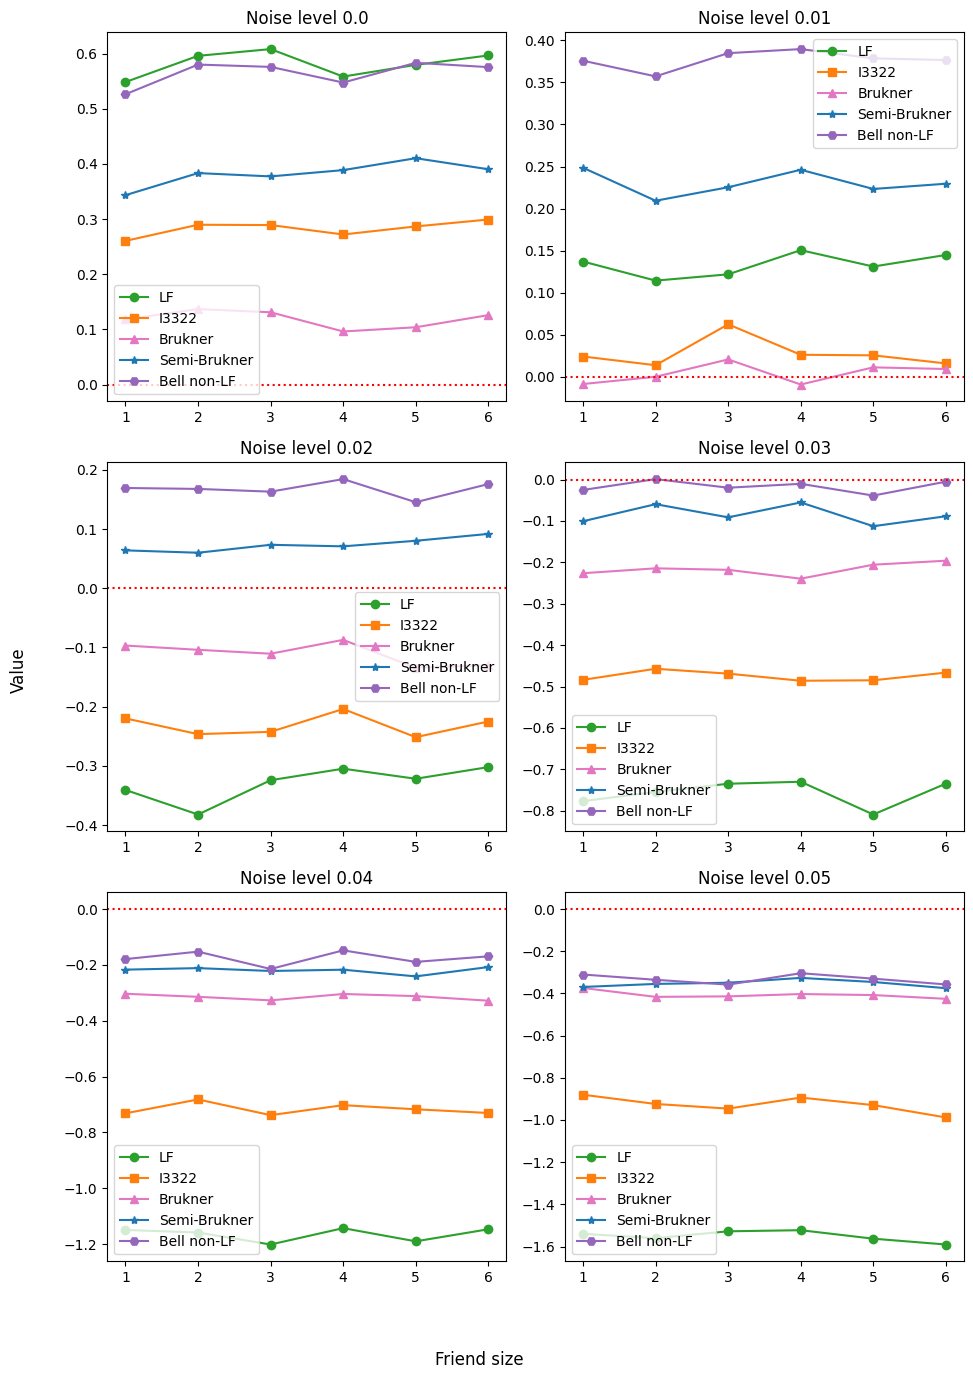

In [111]:
plot_friend_size_per_noise_levels(
    plot_data=plot_data, 
    noise_levels=noise_levels, 
    friend_sizes=friend_sizes, 
    plot_file_name="ghz_friend_sizes_vs_noise_levels.pdf"
)

### Plot grid

In [44]:
def data_violation_grid(friend_sizes: list[int], shots: int):
    plot_data = {
        "simulator_values": [],
        "depolarizing_values_1": [],        
        "depolarizing_values_5": [],                
    }
    
    print("Running data for simulator...")
    for friend_size in friend_sizes:
        print(f"{friend_size=}")        
        plot_data["simulator_values"].append(
            run_experiment(
                backend=qiskit.Aer.get_backend("aer_simulator"),
                noise_model=None,
                friend_size=friend_size,
                shots=shots,
                verbose=True
            )
        )
        
    print("Running data for 1% depolarizing noise...")
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01, 1), ["u1", "u2", "u3"])
    for friend_size in friend_sizes:
        print(f"{friend_size=}")
        plot_data["depolarizing_values_1"].append(
            run_experiment(
                backend=qiskit.Aer.get_backend("aer_simulator"),
                noise_model=noise_model,
                friend_size=friend_size,
                shots=shots,
                verbose=True
            )
        ) 
        
    print("Running data for 5% depolarizing noise...")
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(depolarizing_error(0.05, 1), ["u1", "u2", "u3"])
    for friend_size in friend_sizes:
        print(f"{friend_size=}")
        plot_data["depolarizing_values_5"].append(
            run_experiment(
                backend=qiskit.Aer.get_backend("aer_simulator"),
                noise_model=noise_model,
                friend_size=friend_size,
                shots=shots,
                verbose=True
            )
        )         
    return plot_data

In [45]:
friend_sizes = range(1, 6)
shots = 10_000
plot_data = data_violation_grid(friend_sizes, shots)

Running data for simulator...
friend_size=1
******Inequalities******
semi_brukner=0.3889999999999998 -- is violated: True
brukner=0.11719999999999997 -- is violated: True
lf=0.5906666666666665 -- is violated: True
I3322=0.27993333333333315 -- is_violated: True
bell_non_lf=0.5699999999999998 -- is_violated: True
**************************
friend_size=2
******Inequalities******
semi_brukner=0.3757999999999999 -- is violated: True
brukner=0.11460000000000026 -- is violated: True
lf=0.6026666666666669 -- is violated: True
I3322=0.2796000000000003 -- is_violated: True
bell_non_lf=0.5582000000000003 -- is_violated: True
**************************
friend_size=3
******Inequalities******
semi_brukner=0.38260000000000005 -- is violated: True
brukner=0.1160000000000001 -- is violated: True
lf=0.5883999999999991 -- is violated: True
I3322=0.2914000000000003 -- is_violated: True
bell_non_lf=0.5633999999999997 -- is_violated: True
**************************
friend_size=4
******Inequalities******
sem

{'simulator_values': [{'lf': [0.5906666666666665],
   'I3322': [0.27993333333333315],
   'brukner': [0.11719999999999997],
   'semi_brukner': [0.3889999999999998],
   'bell_non_lf': [0.5699999999999998]},
  {'lf': [0.6026666666666669],
   'I3322': [0.2796000000000003],
   'brukner': [0.11460000000000026],
   'semi_brukner': [0.3757999999999999],
   'bell_non_lf': [0.5582000000000003]},
  {'lf': [0.5883999999999991],
   'I3322': [0.2914000000000003],
   'brukner': [0.1160000000000001],
   'semi_brukner': [0.38260000000000005],
   'bell_non_lf': [0.5633999999999997]},
  {'lf': [0.595133333333334],
   'I3322': [0.2955333333333332],
   'brukner': [0.12080000000000002],
   'semi_brukner': [0.39700000000000024],
   'bell_non_lf': [0.5834000000000001]},
  {'lf': [0.6006],
   'I3322': [0.30326666666666746],
   'brukner': [0.1374000000000004],
   'semi_brukner': [0.3685999999999998],
   'bell_non_lf': [0.5699999999999998]}],
 'depolarizing_values_1': [{'lf': [0.10026666666666717],
   'I3322': [

In [18]:
def plot_violation_grid(plot_data, friend_sizes):
    fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(10, 8))

    # Plot: simulator
    axs[0, 0].plot(friend_sizes, extract_values_from_list_of_dicts("lf", simulator_values), marker="o", color="tab:green")
    axs[0, 0].set_title("LF")
    axs[0, 0].set_xticks(friend_sizes)

    axs[0, 1].plot(friend_sizes, extract_values_from_list_of_dicts("I3322", simulator_values), marker="s", color="tab:orange")
    axs[0, 1].set_title("I3322")
    axs[0, 1].set_xticks(friend_sizes)

    axs[0, 2].plot(friend_sizes, extract_values_from_list_of_dicts("brukner", simulator_values), marker="^", color="tab:pink")
    axs[0, 2].set_title("Brukner")
    axs[0, 2].set_xticks(friend_sizes)

    axs[0, 3].plot(friend_sizes, extract_values_from_list_of_dicts("semi_brukner", simulator_values), marker="*", color="tab:blue")
    axs[0, 3].set_title("Semi-Brukner")
    axs[0, 3].set_xticks(friend_sizes)

    axs[0, 4].plot(friend_sizes, extract_values_from_list_of_dicts("bell_non_lf", simulator_values), marker="H", color="tab:purple")
    axs[0, 4].set_title("Bell non-LF")
    axs[0, 4].set_xticks(friend_sizes)
    
    # Adding a red dotted line at y = 0 for each subplot for violation threshold.
    for ax in axs.flat:
        ax.axhline(y=0, color="tab:red", linestyle="--")

    # Set row labels on the right side
    # fig.text(1, 0.89, "Simulator", ha="center", va="center", rotation=-90, fontsize=8)
    # fig.text(1, 0.7, "1% depolarizing", ha="center", va="center", rotation=-90, fontsize=8)
    # fig.text(1, 0.52, "10% depolarizing", ha="center", va="center", rotation=-90, fontsize=8)
    # fig.text(1, 0.35, "FakeKolkata", ha="center", va="center", rotation=-90, fontsize=8)
    # fig.text(1, 0.15, "FakeKolkata (w/ZNE)", ha="center", va="center", rotation=-90, fontsize=8)

    row_titles = [
        "Simulator", "1% depolarizing", "10% depolarizing"
    ]
    num_rows = len(axs)
    for i in range(num_rows):
        row_label_y_position = axs[i, 0].get_position().y0 + axs[i, 0].get_position().height / 2
        fig.text(1, row_label_y_position, row_titles[i], ha="center", va="center", rotation=-90, fontsize=10)

    fig.supxlabel("Friend size")
    fig.supylabel("Violation")

    plt.tight_layout()

    plt.savefig("simulator_violations.pdf", bbox_inches="tight")
    plt.show()

Running data for simulator...


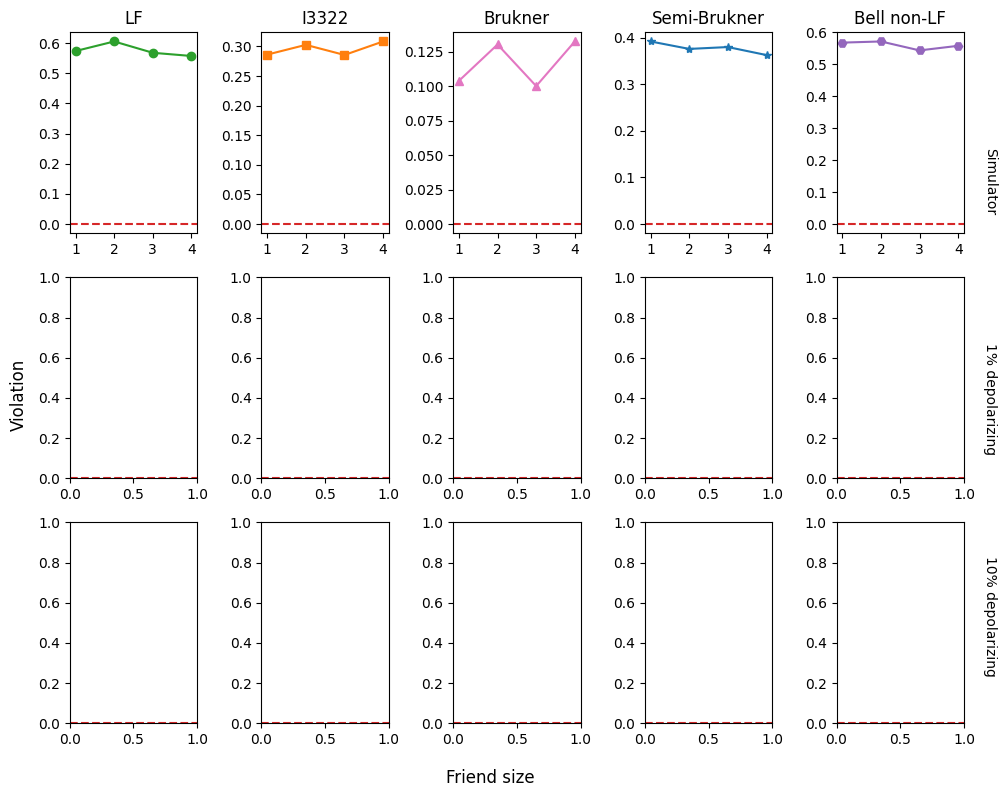

In [19]:
friend_sizes = range(1, 5)
shots = 10_000
plot_violation_grid(friend_sizes, shots)

### Multiple plots

In [ ]:
friend_sizes = range(1, 6)
shots = 10_000

# Data: Simulator
print("Running data for simulator...")
simulator_values = []
for friend_size in friend_sizes:
    simulator_values.append(run_experiment(
        backend=qiskit.Aer.get_backend("aer_simulator"),
        noise_model=None,
        friend_size=friend_size,
        shots=shots,
    ))
        
# Data: 1% depolarizing simulator
print("Running data for 1% depolarizing noise simulator...")
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01, 1), ["u1", "u2", "u3"])
depolarizing_values_1 = []
for friend_size in friend_sizes:
    depolarizing_values_1.append(run_experiment(
    backend=qiskit.Aer.get_backend("aer_simulator"),
    noise_model=noise_model,
    friend_size=friend_size,
    shots=shots,
))
    
# # Data: 10% depolarizing simulator
# print("Running data for 10% depolarizing noise simulator...")
# noise_model = NoiseModel()
# noise_model.add_all_qubit_quantum_error(depolarizing_error(0.1, 1), ["u1", "u2", "u3"])
# depolarizing_values_10 = run_experiment(
#     backend=qiskit.Aer.get_backend("aer_simulator"),
#     noise_model=noise_model,
#     friend_sizes=friend_sizes,
#     shots=shots,
# )

# friend_sizes = range(1,4)
# # Data: FakeKolkata
# print("Running data for FakeKolkata...")
# backend = fake_provider.FakeKolkata()
# noise_model = NoiseModel.from_backend(backend)
# fake_kolkata_values = run_experiment(
#     backend=backend,
#     noise_model=noise_model,
#     friend_sizes=friend_sizes,
#     shots=shots,
# )

# # Data: FakeKolkata (with ZNE)
# print("Running data for FakeKolkata (with ZNE)...")
# backend = fake_provider.FakeKolkata()
# noise_model = NoiseModel.from_backend(backend)
# fake_kolkata_values_with_zne = run_experiment(
#     backend=backend,
#     noise_model=noise_model,
#     friend_sizes=friend_sizes,
#     shots=shots,
#     use_zne=True,
# )

In [ ]:
print(simulator_values)
lf = [d["lf"][0] for d in simulator_values if "lf" in d]
print(lf)

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(10, 8))

# Plot: simulator
axs[0, 0].plot(friend_sizes, extract_values_from_list_of_dicts("lf", simulator_values), marker="o", color="tab:green")
axs[0, 0].set_title("LF")
axs[0, 0].set_xticks(friend_sizes)

axs[0, 1].plot(friend_sizes, extract_values_from_list_of_dicts("I3322", simulator_values), marker="s", color="tab:orange")
axs[0, 1].set_title("I3322")
axs[0, 1].set_xticks(friend_sizes)

axs[0, 2].plot(friend_sizes, extract_values_from_list_of_dicts("brukner", simulator_values), marker="^", color="tab:pink")
axs[0, 2].set_title("Brukner")
axs[0, 2].set_xticks(friend_sizes)

axs[0, 3].plot(friend_sizes, extract_values_from_list_of_dicts("semi_brukner", simulator_values), marker="*", color="tab:blue")
axs[0, 3].set_title("Semi-Brukner")
axs[0, 3].set_xticks(friend_sizes)

axs[0, 4].plot(friend_sizes, extract_values_from_list_of_dicts("bell_non_lf", simulator_values), marker="H", color="tab:purple")
axs[0, 4].set_title("Bell non-LF")
axs[0, 4].set_xticks(friend_sizes)

# Plot: 1% depolarizing noise
axs[1, 0].plot(friend_sizes, extract_values_from_list_of_dicts("lf", depolarizing_values_1), marker="o", color="tab:green")
axs[1, 0].set_xticks(friend_sizes)

axs[1, 1].plot(friend_sizes, extract_values_from_list_of_dicts("I3322", depolarizing_values_1), marker="s", color="tab:orange")
axs[1, 1].set_xticks(friend_sizes)

axs[1, 2].plot(friend_sizes, extract_values_from_list_of_dicts("brukner", depolarizing_values_1), marker="^", color="tab:pink")
axs[1, 2].set_xticks(friend_sizes)

axs[1, 3].plot(friend_sizes, extract_values_from_list_of_dicts("semi_brukner", depolarizing_values_1), marker="*", color="tab:blue")
axs[1, 3].set_xticks(friend_sizes)

axs[1, 4].plot(friend_sizes, extract_values_from_list_of_dicts("bell_non_lf", depolarizing_values_1), marker="H", color="tab:purple")
axs[1, 4].set_xticks(friend_sizes)

# # Plot: 10% depolarizing noise
# axs[2, 0].plot(friend_sizes, depolarizing_values_10["lf"], marker="o", color="tab:green")
# axs[2, 0].set_xticks(friend_sizes)

# axs[2, 1].plot(friend_sizes, depolarizing_values_10["I3322"], marker="s", color="tab:orange")
# axs[2, 1].set_xticks(friend_sizes)

# axs[2, 2].plot(friend_sizes, depolarizing_values_10["brukner"], marker="^", color="tab:pink")
# axs[2, 2].set_xticks(friend_sizes)

# axs[2, 3].plot(friend_sizes, depolarizing_values_10["semi_brukner"], marker="*", color="tab:blue")
# axs[2, 3].set_xticks(friend_sizes)

# axs[2, 4].plot(friend_sizes, depolarizing_values_10["bell_non_lf"], marker="H", color="tab:purple")
# axs[2, 4].set_xticks(friend_sizes)

# friend_sizes = range(1,4)

# # Plot: FakeKolkata
# axs[3, 0].plot(friend_sizes, fake_kolkata_values["lf"], marker="o", color="tab:green")
# axs[3, 0].set_xticks(friend_sizes)

# axs[3, 1].plot(friend_sizes, fake_kolkata_values["I3322"], marker="s", color="tab:orange")
# axs[3, 1].set_xticks(friend_sizes)

# axs[3, 2].plot(friend_sizes, fake_kolkata_values["brukner"], marker="^", color="tab:pink")
# axs[3, 2].set_xticks(friend_sizes)

# axs[3, 3].plot(friend_sizes, fake_kolkata_values["semi_brukner"], marker="*", color="tab:blue")
# axs[3, 3].set_xticks(friend_sizes)

# axs[3, 4].plot(friend_sizes, fake_kolkata_values["bell_non_lf"], marker="H", color="tab:purple")
# axs[3, 4].set_xticks(friend_sizes)

# # Plot: FakeKolkata (with ZNE)
# axs[4, 0].plot(friend_sizes, fake_kolkata_values_with_zne["lf"], marker="o", color="tab:green")
# axs[4, 0].set_xticks(friend_sizes)

# axs[4, 1].plot(friend_sizes, fake_kolkata_values_with_zne["I3322"], marker="s", color="tab:orange")
# axs[4, 1].set_xticks(friend_sizes)

# axs[4, 2].plot(friend_sizes, fake_kolkata_values_with_zne["brukner"], marker="^", color="tab:pink")
# axs[4, 2].set_xticks(friend_sizes)

# axs[4, 3].plot(friend_sizes, fake_kolkata_values_with_zne["semi_brukner"], marker="*", color="tab:blue")
# axs[4, 3].set_xticks(friend_sizes)

# axs[4, 4].plot(friend_sizes, fake_kolkata_values_with_zne["bell_non_lf"], marker="H", color="tab:purple")
# axs[4, 4].set_xticks(friend_sizes)


# Adding a red dotted line at y = 0 for each subplot for violation threshold.
for ax in axs.flat:
    ax.axhline(y=0, color="tab:red", linestyle="--")

# Set row labels on the right side
# fig.text(1, 0.89, "Simulator", ha="center", va="center", rotation=-90, fontsize=8)
# fig.text(1, 0.7, "1% depolarizing", ha="center", va="center", rotation=-90, fontsize=8)
# fig.text(1, 0.52, "10% depolarizing", ha="center", va="center", rotation=-90, fontsize=8)
# fig.text(1, 0.35, "FakeKolkata", ha="center", va="center", rotation=-90, fontsize=8)
# fig.text(1, 0.15, "FakeKolkata (w/ZNE)", ha="center", va="center", rotation=-90, fontsize=8)

row_titles = [
    "Simulator", "1% depolarizing", "10% depolarizing"
]
num_rows = len(axs)
for i in range(num_rows):
    row_label_y_position = axs[i, 0].get_position().y0 + axs[i, 0].get_position().height / 2
    fig.text(1, row_label_y_position, row_titles[i], ha="center", va="center", rotation=-90, fontsize=10)

fig.supxlabel("Friend size")
fig.supylabel("Violation")

plt.tight_layout()

plt.savefig("simulator_violations.pdf", bbox_inches="tight")
plt.show()